In [ ]:
% pip install networkx
% pip install ipykernel
% pip install pandas
% pip install matplotlib

In [12]:
import networkx as nx
from ska_control_model import ObsState
import pandas as pd

# define the states of the system
obs_states = [os.name for os in ObsState]

# define which states are reachable using the reset procedure
reachable_states = obs_states.copy()
reachable_states.remove(ObsState.FAULT.name)
reachable_states.remove(ObsState.RESETTING.name)
is_reachable = {
    state: state in reachable_states
    for state in obs_states
}

# define which states support the abort command
abortable_states = [
    ObsState.RESOURCING.name,
    ObsState.IDLE.name,
    ObsState.CONFIGURING.name,
    ObsState.READY.name,
    ObsState.SCANNING.name,
    ObsState.RESETTING.name,
]
is_abortable = {
    state: state in abortable_states
    for state in obs_states
}

# define which states support the restart command
restartable_states = [
    ObsState.FAULT.name,
    ObsState.ABORTED.name,
]
is_restartable = {
    state: state in restartable_states
    for state in obs_states
}

pd.DataFrame({
    'state': obs_states,
    'is_reachable': [is_reachable[state] for state in obs_states],
    'is_abortable': [is_abortable[state] for state in obs_states],
    'is_restartable': [is_restartable[state] for state in obs_states],
}).set_index('state')


,is_reachable,is_abortable,is_restartable
state,,,
EMPTY,True,False,False
RESOURCING,True,True,False
IDLE,True,True,False
CONFIGURING,True,True,False
READY,True,True,False
SCANNING,True,True,False
ABORTING,True,False,False
ABORTED,True,False,True
RESETTING,False,True,False


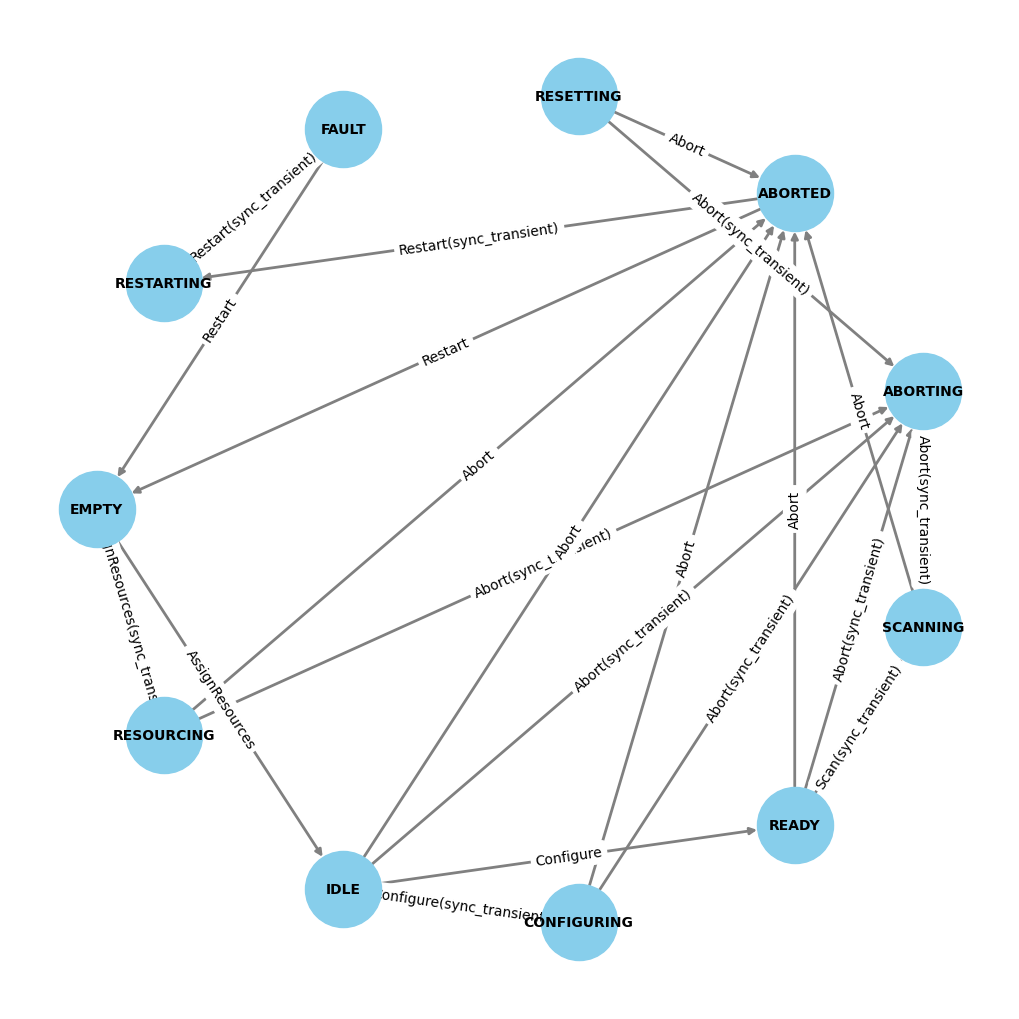

In [44]:
# define the transitions between states
os_state_procedure = nx.DiGraph()
os_state_procedure.add_nodes_from(obs_states)

# define the transitions
os_state_procedure.add_edge(ObsState.EMPTY.name, ObsState.IDLE.name, label="AssignResources")
os_state_procedure.add_edge(ObsState.EMPTY.name, ObsState.RESOURCING.name, label="AssignResources(sync_transient)")
os_state_procedure.add_edge(ObsState.IDLE.name, ObsState.READY.name, label="Configure")
os_state_procedure.add_edge(ObsState.IDLE.name, ObsState.CONFIGURING.name, label="Configure(sync_transient)")
os_state_procedure.add_edge(ObsState.READY.name, ObsState.SCANNING.name, label="Scan(sync_transient)")

for state in abortable_states:
    os_state_procedure.add_edge(state, ObsState.ABORTED.name, label="Abort")
    os_state_procedure.add_edge(state, ObsState.ABORTING.name, label="Abort(sync_transient)")

for state in restartable_states:
    os_state_procedure.add_edge(state, ObsState.EMPTY.name, label="Restart")
    os_state_procedure.add_edge(state, ObsState.RESTARTING.name, label="Restart(sync_transient)")

# os_state_procedure.add_edge(ObsState.ABORTING.name, ObsState.ABORTED.name, label="wait")
# os_state_procedure.add_edge(ObsState.RESTARTING.name, ObsState.EMPTY.name, label="wait")

# plot the state transition diagram (with lables)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
pos = nx.shell_layout(os_state_procedure)

nx.draw(os_state_procedure, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', width=2, edge_cmap=plt.cm.Blues)
edge_labels = nx.get_edge_attributes(os_state_procedure, 'label')
nx.draw_networkx_edge_labels(os_state_procedure, pos, edge_labels=edge_labels)
plt.show()


## Question: which states are reachable from which states?

In [45]:
# calculate the reachability matrix
reachability_matrix = nx.floyd_warshall_numpy(os_state_procedure)
print("Reachability matrix(rows are starting points, cols are targets):")
pd.DataFrame(reachability_matrix, index=obs_states, columns=obs_states)

Reachability matrix(rows are starting points, cols are targets):


,EMPTY,RESOURCING,IDLE,CONFIGURING,READY,SCANNING,ABORTING,ABORTED,RESETTING,FAULT,RESTARTING
EMPTY,0.0,1.0,1.0,2.0,2.0,3.0,2.0,2.0,inf,inf,3.0
RESOURCING,2.0,0.0,3.0,4.0,4.0,5.0,1.0,1.0,inf,inf,2.0
IDLE,2.0,3.0,0.0,1.0,1.0,2.0,1.0,1.0,inf,inf,2.0
CONFIGURING,2.0,3.0,3.0,0.0,4.0,5.0,1.0,1.0,inf,inf,2.0
READY,2.0,3.0,3.0,4.0,0.0,1.0,1.0,1.0,inf,inf,2.0
SCANNING,2.0,3.0,3.0,4.0,4.0,0.0,1.0,1.0,inf,inf,2.0
ABORTING,inf,inf,inf,inf,inf,inf,0.0,inf,inf,inf,inf
ABORTED,1.0,2.0,2.0,3.0,3.0,4.0,3.0,0.0,inf,inf,1.0
RESETTING,2.0,3.0,3.0,4.0,4.0,5.0,1.0,1.0,0.0,inf,2.0
FAULT,1.0,2.0,2.0,3.0,3.0,4.0,3.0,3.0,inf,0.0,1.0


Answer:

- each state is reachable from each state, except:
- RESETTING and FAULT are currently not reachable from any other states
  (except for themselves)
- from ABORTING and RESTARTING you cannot currently reach any other state
  (except for themselves)

## Question: what is the longest non-infinite path in the state machine?

In [53]:
reachability_lengths = reachability_matrix[reachability_matrix != float('inf')].flatten()
pd.Series(reachability_lengths).describe()

count    85.000000
mean      2.058824
std       1.339447
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       5.000000
dtype: float64

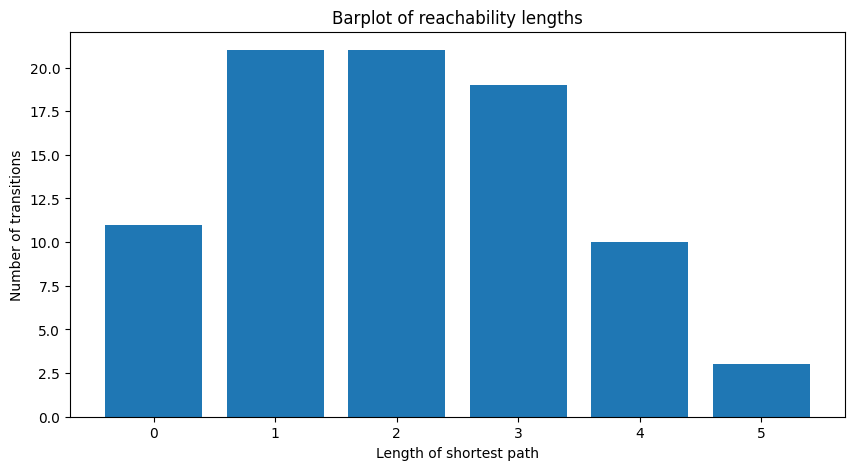

In [52]:
# count the frequency of each length in the reachability matrix
from collections import Counter

reachability_lengths = reachability_matrix[reachability_matrix != float('inf')].flatten()
reachability_length_counts = Counter(reachability_lengths)
reachability_length_counts

# plot the reachability length barplot
plt.figure(figsize=(10, 5))
plt.bar(reachability_length_counts.keys(), reachability_length_counts.values())
plt.xlabel("Length of shortest path")
plt.ylabel("Number of transitions")
plt.title("Barplot of reachability lengths")
plt.show()